In [112]:
# Lecture 4 - Activations, gradients and batch norm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [113]:
# Read in the text file
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [114]:
len(words)

32033

In [115]:
# Build vocabulary of characters and mappings to integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [116]:
# build the dataset
block_size = 3 # input context length parameter

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182394, 3]) torch.Size([182394])
torch.Size([22799, 3]) torch.Size([22799])
torch.Size([22953, 3]) torch.Size([22953])


In [117]:
# MLP revisited
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the neural net

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5 # kaiming initialisation
#b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad=True

12097


In [118]:
# MLP optimisation
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # construct mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # batch normalisation
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2900
  10000/ 200000: 2.1912
  20000/ 200000: 2.5012
  30000/ 200000: 2.2187
  40000/ 200000: 2.3114
  50000/ 200000: 1.6770
  60000/ 200000: 2.3388
  70000/ 200000: 1.9058
  80000/ 200000: 2.0004
  90000/ 200000: 1.8886
 100000/ 200000: 2.0835
 110000/ 200000: 2.5869
 120000/ 200000: 2.0050
 130000/ 200000: 2.2077
 140000/ 200000: 2.3037
 150000/ 200000: 1.9820
 160000/ 200000: 1.8827
 170000/ 200000: 1.7823
 180000/ 200000: 1.5075
 190000/ 200000: 1.4235


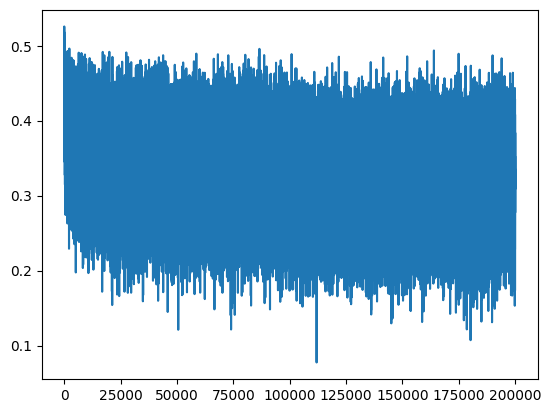

In [119]:
plt.plot(lossi)

In [120]:
# # calculate the batch norm at the end of training - replaced with running mean/std during training

# with torch.no_grad():
#     # pass the training set through
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     # measure the mean and std
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)


In [121]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalisation
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')


train 2.0681278705596924
val 2.1164133548736572


In [122]:
# sample from the model
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(emb.shape[0], -1)
        hpreact = embcat @ W1 #+ b1
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # batch normalisation
        h = torch.tanh(hpreact)
#       h = torch.tanh(emb.view(1, -1) @ W1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

junide.
jakasir.
pressy.
adin.
kai.
rito.
sabrayel.
kalania.
zamilena.
jadeyah.
rwi.
tayse.
siely.
arteziaraumestfontum.
maryas.
mah.
jaylie.
raayae.
anna.
jaani.


In [143]:
# Training a deeper neural network, using a structure analogous to Pytorch

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropagation)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd = 10 # dimensionality of character embedding vectors
n_hidden = 100 # of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True

47024


In [144]:
# same optimisation as previously
max_steps = 500000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X, Y
    
    # forward pass
    emb = C[Xb] # embedding character inputs into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])

      0/ 500000: 3.2938
  10000/ 500000: 2.5066
  20000/ 500000: 2.3615
  30000/ 500000: 2.4740
  40000/ 500000: 2.0848
  50000/ 500000: 2.0762
  60000/ 500000: 2.2957
  70000/ 500000: 2.0338
  80000/ 500000: 2.1746
  90000/ 500000: 1.9114
 100000/ 500000: 2.5388
 110000/ 500000: 2.2252
 120000/ 500000: 1.9272
 130000/ 500000: 2.2953
 140000/ 500000: 1.8629
 150000/ 500000: 2.2424
 160000/ 500000: 2.2789
 170000/ 500000: 1.8032
 180000/ 500000: 1.9629
 190000/ 500000: 2.2388
 200000/ 500000: 2.2291
 210000/ 500000: 2.0090
 220000/ 500000: 2.0569
 230000/ 500000: 1.6759
 240000/ 500000: 2.2517
 250000/ 500000: 2.0139
 260000/ 500000: 1.8011
 270000/ 500000: 2.2145
 280000/ 500000: 2.2175
 290000/ 500000: 2.3628
 300000/ 500000: 1.8247
 310000/ 500000: 1.9863
 320000/ 500000: 2.0446
 330000/ 500000: 2.2442
 340000/ 500000: 1.9058
 350000/ 500000: 2.1205
 360000/ 500000: 2.1767
 370000/ 500000: 1.7298
 380000/ 500000: 2.2639
 390000/ 500000: 2.1171
 400000/ 500000: 2.1947
 410000/ 500000:

layer 2 (      Tanh): mean +0.00, std 0.70, saturated: 15.38%
layer 5 (      Tanh): mean -0.01, std 0.73, saturated: 17.00%
layer 8 (      Tanh): mean -0.01, std 0.76, saturated: 17.31%
layer 11 (      Tanh): mean -0.00, std 0.76, saturated: 19.16%
layer 14 (      Tanh): mean +0.01, std 0.77, saturated: 21.22%


Text(0.5, 1.0, 'activation distribution')

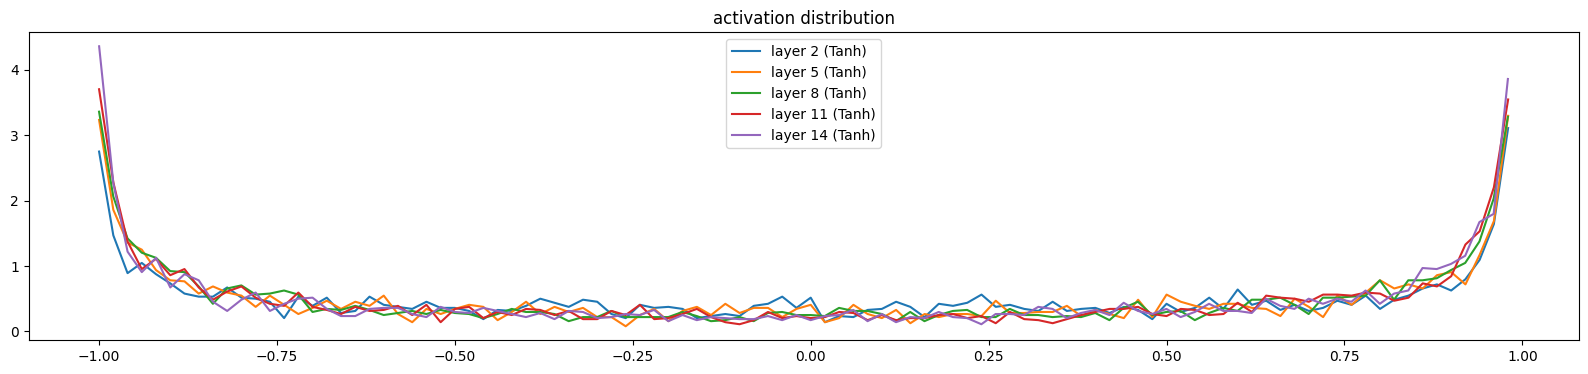

In [145]:
# visualise histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 5.103690e-03
layer 5 (      Tanh): mean -0.000000, std 4.767023e-03
layer 8 (      Tanh): mean +0.000000, std 4.465272e-03
layer 11 (      Tanh): mean -0.000000, std 4.051239e-03
layer 14 (      Tanh): mean +0.000000, std 4.084890e-03


Text(0.5, 1.0, 'gradient distribution')

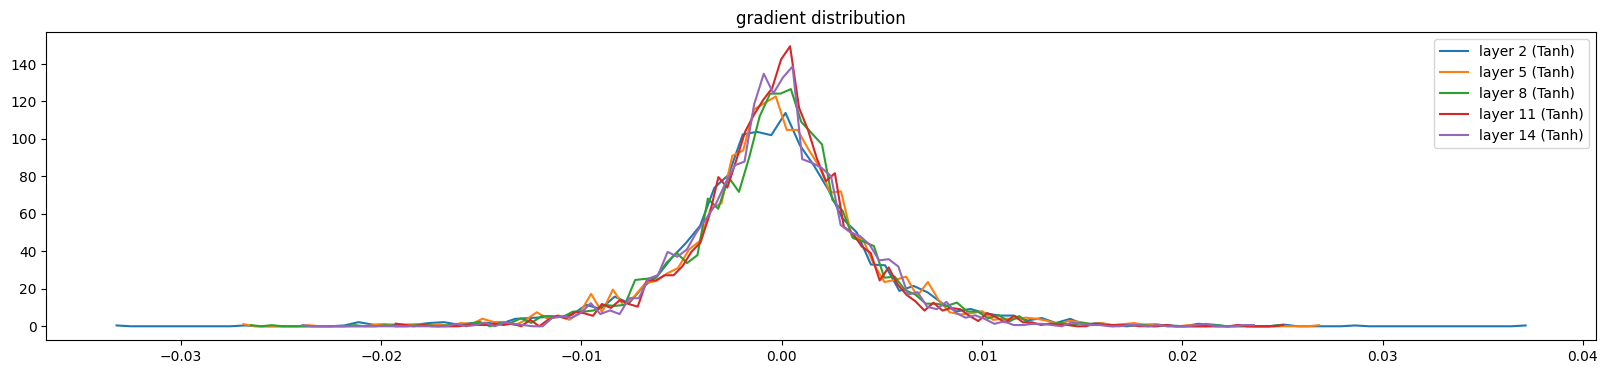

In [146]:
# visualise histograms
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.712261e-02 | grad:data ratio 1.557348e-02
weight  (30, 100) | mean -0.000157 | std 1.151399e-02 | grad:data ratio 2.779800e-02
weight (100, 100) | mean +0.000070 | std 7.714921e-03 | grad:data ratio 3.090271e-02
weight (100, 100) | mean -0.000051 | std 7.633030e-03 | grad:data ratio 3.099905e-02
weight (100, 100) | mean -0.000035 | std 6.818462e-03 | grad:data ratio 2.837742e-02
weight (100, 100) | mean +0.000023 | std 5.660660e-03 | grad:data ratio 2.440892e-02
weight  (100, 27) | mean -0.000031 | std 9.324850e-03 | grad:data ratio 2.790072e-02


Text(0.5, 1.0, 'weights gradient distribution')

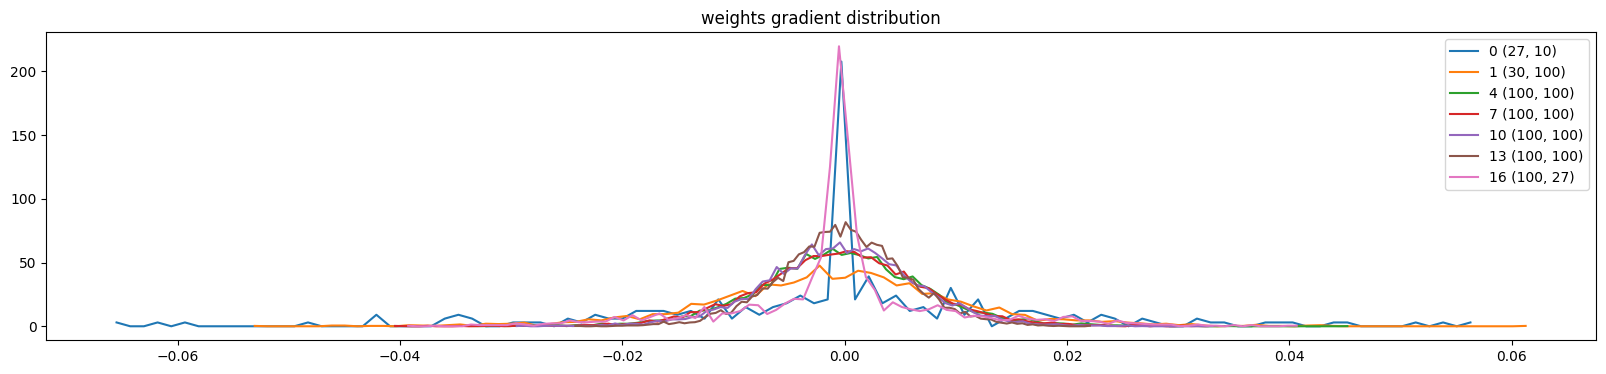

In [147]:
# visualise histograms
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

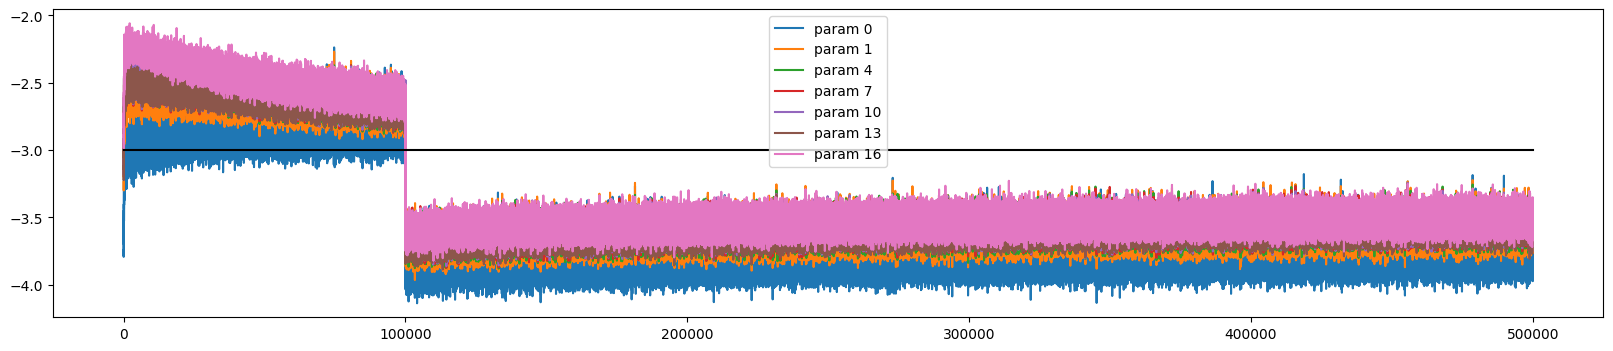

In [148]:
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

In [149]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 1.9927351474761963
val 2.086160898208618


In [150]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

montaymyah.
see.
madhayla.
reisha.
endra.
grace.
kaielin.
shi.
jen.
eden.
estanaraelyn.
malara.
noshubergihiriel.
kin.
roselionnie.
casu.
zayven.
jamell.
elsyn.
ajahsanyah.
